## Chem 277B Final Project
# Retrosynthesis Pathway Optimization Augmented by Molecular Analogs
# ~ An Elegant Presentation ~

#### Fest Muhire, Paul Graggs, Haris Saeed, Girnar Joshi

>>

This version of the project is more user focused.

please see the jupyter notebook "Full_Pipeline.ipynb" for full implementation.

(most code is hidden in modules and the neural network models were trained elsewhere and simply loaded here)

>>

Imports, and Connecting the Drive

In [ ]:
csv_path = '2001_Sep2016_USPTOapplications_smiles_yield_ok_all_data.csv'
module_path = 'FinalProjectUtils.py'
folder_path = 'files'
file_id = '1JljlowOYryPHv8SeLOzp8wO7IRelLUwu'
url = f"https://drive.google.com/uc?id={file_id}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

# Basic Imports
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
!pip install rdkit
!pip install torch_geometric
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MolToSmiles
from rdkit import DataStructs
from rdkit.Chem import rdmolops
from torch_geometric.data import Data, Batch
from collections import defaultdict
from tqdm import tqdm
!pip install deepchem
from deepchem.feat import MolGraphConvFeaturizer
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# Neural Network Specific Imports
import torch.nn.functional as F
from torch.nn import BatchNorm1d
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GINConv
from torch_geometric.nn import GATConv, TopKPooling
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_max_pool
from torch_geometric.nn import global_add_pool
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.optim as optim
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch_geometric.nn import global_mean_pool
from tqdm import tqdm
import torch.optim
from torch.utils.data import Dataset
import re
import json

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [3]:
from FinalProjectUtils import NewGAT, Predictor
from FinalProjectUtils import *
from YieldPredictor import *

>>

### Loading the full data set : USPTO 50k

In [ ]:
dfFull = pd.read_csv(url, sep="\t")

<ipython-input-4-75222bb2d208>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  dfFull = pd.read_csv(csv_path, sep="\t")


>

Some model hyper parameters, gpu settings, and model initialization

In [5]:
ATOM_DIM = 33
EDGE_DIM = 11
embedding_size = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We instatiate our models both the encoder and predictor
model = NewGAT(feature_size=ATOM_DIM, edge_dim=EDGE_DIM).to(device) # Embedding generator
mlp = Predictor(embedding_size=embedding_size).to(device)

model.load_state_dict(torch.load(folder_path +'/best_gnn.pt'))
mlp.load_state_dict(torch.load(folder_path+ '/best_mlp.pt'))

<All keys matched successfully>

>>

This module (TheProcess) contains all the neural nets and supporting functions, and dataframe / data processing functions. This module is what gets revealed in the Full_Pipeline notebook which really showcases all the work we did.

In [6]:
from TheProcess import *
from TheProcess import SmilesVAE

>>

Prepping the internal molecular set for the pipeline

In [7]:
# selecting the types of reactins we want in the similarity search data set
# by choosing the number of reactants we want to all owi na reaction
num_rxnt_lst = [1, 2, 3, 4]

# constructing a dataframe of such num_reactant allowed reactions
dfrp = make_search_alg_df(dfFull, num_rxnt_lst)

/content/drive/MyDrive/Chem277_final/TheProcess.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_df[['Reactants', 'Solvent/Catalyst', 'Product']] = y_df['ReactionSmiles'].str.split('>', expand=True)
/content/drive/MyDrive/Chem277_final/TheProcess.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_df[['Reactants', 'Solvent/Catalyst', 'Product']] = y_df['ReactionSmiles'].str.split('>', expand=True)
/content/drive/MyDrive/Chem277_final/TheProcess.py:134: SettingWithCopyWarning: 
A value is trying t

>>

Here we are building set_all which is a set of all the
molecules that the pipeline will search through during the similarity search.

We also take a look at how many molecules appear in both the reactant and product sets.

In [8]:
set_all, set_p, set_r = get_unique_sets(dfrp)

Number of unique SMILES strings (overall): 38910
Number of unique reactant SMILES strings: 21540
Number of unique product SMILES strings: 21806
Count (including duplicates): 4436
Count (unique items only): 4436


We also build the token dictionary for the VAE and instantiate the model:

In [9]:
vocab_size=1193

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = SmilesVAE(vocab_size=1193, emb_dim=64, hidden_dim=128, latent_dim=64).to(device)


folder_path = '/content/drive/MyDrive/Chem277_final'
vae.load_state_dict(torch.load(folder_path +'/smiles_vae_full_model.pt'))

<All keys matched successfully>

## The Pipeline << The System << The Process

These are the functions that integrate and employ all the ML models, and prepped datasets to work together produce retrosynthetic steps from a target molecule.

In [11]:
def pipeline(target, internal_set):

  #1. product to synthons
  synthons = syn_pred(target)
  print("num synthons for target: ", len(synthons))

  #2. remove taget from dataset
  internal_set.discard(target)

  #3. synthons to reactants
  print("Conducting Sim Search: ")
  reactants = []
  for s in synthons:
    x = sim_search(s, vae, internal_set)
    reactants.append(x)

  #4. predict Yield btwn : reactatns & target
  print("conducting yield prediction: ")
  Y = Ypredict(reactants, target, model, mlp, DataLoader)
  print("Yield: ", Y)

  #4.1 collect full step
  step = [reactants, Y, target]

  #5.  select best terminal reactant (tR)
  best = 0
  tR = None
  for r in reactants:
    l = len(syn_pred(r))
    if l > best:
      best = l
      tR = r
  print("num synths for tR: ", best)
  print("terminal Reactant to proceed with: ", tR)

  #6. return the step = [reactants, Yield, target]
  #   and the next target within the reactants
  return step, tR

In [12]:
def system(target, num_steps = 3, internal_set = None):

  pathway = []
  steps = []

  ctR = ""   # current terminal reactant

  for i in range(num_steps):
    print(" \t step:   _", i+1, "/", num_steps, "_")
    if i == 0:
      step, tR = pipeline(target, internal_set)
      steps.append(step)

    if i !=0:
      step, tR = pipeline(ctR, internal_set)
      steps.append(step)

    ctR = tR

  OY = 1.0 # overall Yield
  for step in steps:
    Y = step[1]
    if isinstance(Y, float):
      OY *= (Y/100.0)

  pathway = []
  pathway.append(target)
  for i in range (len(steps)):
    pathway.append(steps[i][1])
    pathway.append(steps[i][0])
  print(pathway)

  return pathway, OY



In [13]:
def process(target, num_pathways, num_steps, set_all_molecules):

  print("target: ", target)

  pathways = []

  internal_set = set_all_molecules.copy()

  # get all the pathways
  for i in range(num_pathways):
    print('\n')
    print("\t PATHWAY: ", i+1 , "/" , num_pathways)
    pathway, OY = system(target, num_steps, internal_set)
    pathways.append( (pathway,OY) )

  # get best yield pathway
  best_pathway = pathways[0]
  for i in pathways:
    print(f"Examining A Pathway : Yield : {i[1]}")
    if i[1] > best_pathway[1]:
      best_pathway = i

  print('\n')
  print("Best Pathway: ", best_pathway)
  print("Best Yield: ", best_pathway[1])
  return best_pathway

>>

>>

>>

### Demonstrations

~ Note that these take some time to run.

progress will be displayed incrementally.

thanks for your patience.

#### Running on Acetaminophen

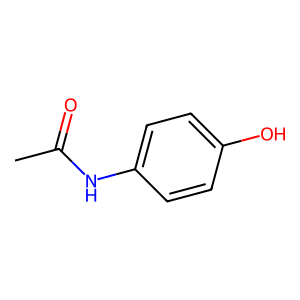

target:  CC(=O)NC1=CC=C(C=C1)O


	 PATHWAY:  1 / 2
 	 step:   _ 1 / 4 _
num synthons for target:  3
Conducting Sim Search: 
~Returning Tanimoto match~: score of: 0.555556
~Returning Tanimoto match~: score of: 0.615385
~Returning Analog~:
conducting yield prediction: 
Yield:  66.66007995605469
num synths for tR:  1
terminal Reactant to proceed with:  CC(C)=O
 	 step:   _ 2 / 4 _
num synthons for target:  1
Conducting Sim Search: 
~Returning Substructre Match~: Tanimoto: 0.625000
conducting yield prediction: 
Yield:  49.677894592285156
num synths for tR:  1
terminal Reactant to proceed with:  CC(=O)C(C)=O
 	 step:   _ 3 / 4 _
num synthons for target:  1
Conducting Sim Search: 
~Returning Synthon~
conducting yield prediction: 
Yield:  57.49353790283203
num synths for tR:  1
terminal Reactant to proceed with:  CC(=O)C(C)=O
 	 step:   _ 4 / 4 _
num synthons for target:  1
Conducting Sim Search: 
~Returning Synthon~
conducting yield prediction: 
Yield:  57.49353790283203
num synths for tR:  

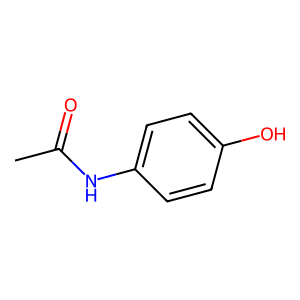

66.66007995605469


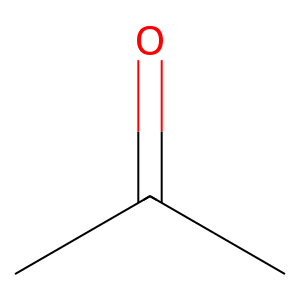

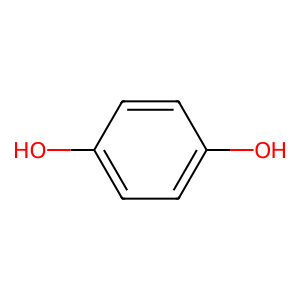

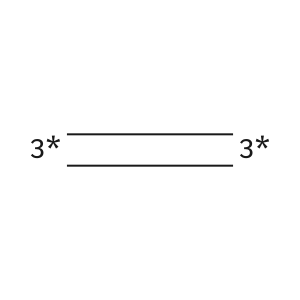

49.677894592285156


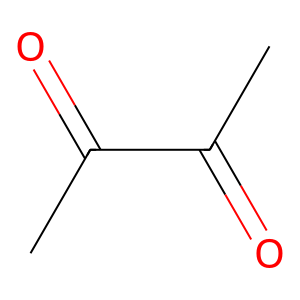

57.49353790283203


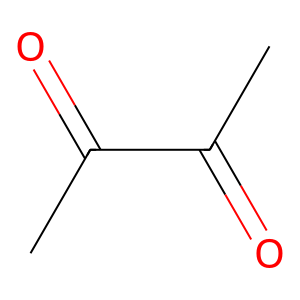

57.49353790283203


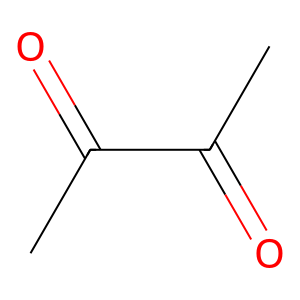

overall yield:  0.10946293284231186


In [14]:
# 1. define target molecule
testmol1 = "CC(=O)NC1=CC=C(C=C1)O" # from pubchem

# 2. take a look at target molecule
display(Draw.MolToImage(Chem.MolFromSmiles(testmol1), size=(300, 300)))

# 3. make a copy of the set of molecules
set_mol = set_all.copy()

# 4. run the process: 2 pathways, 4 steps each
test1 = process(target = testmol1,
                num_pathways = 2,
                num_steps = 4,
                set_all_molecules = set_mol)

# 5. Vizualize the output pathway
path_viz(test1[0])

>>

>>

>>

#### Running on Taxol

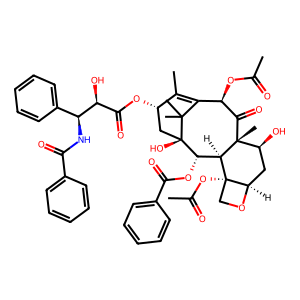

target:  CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@H]3[C@@H]([C@@](C2(C)C)(C[C@@H]1OC(=O)[C@@H]([C@H](C5=CC=CC=C5)NC(=O)C6=CC=CC=C6)O)O)OC(=O)C7=CC=CC=C7)(CO4)OC(=O)C)O)C)OC(=O)C


	 PATHWAY:  1 / 1
 	 step:   _ 1 / 3 _
num synthons for target:  7
Conducting Sim Search: 
~Returning Tanimoto match~: score of: 0.375000
~Returning Tanimoto match~: score of: 0.397590
~Returning Analog~:
~Returning Tanimoto match~: score of: 0.368421
~Returning Analog~:
~Returning Tanimoto match~: score of: 0.555556
~Returning Tanimoto match~: score of: 0.437500
conducting yield prediction: 
Yield:  66.33747863769531
num synths for tR:  5
terminal Reactant to proceed with:  CC(=O)O[C@@]12CO[C@@H]1C[C@H](O)[C@@]1(C)C(=O)[C@H](O)C3=C(C)[C@@H](O)C[C@@](O)([C@@H](OC(=O)c4ccccc4)[C@H]21)C3(C)C
 	 step:   _ 2 / 3 _
num synthons for target:  5
Conducting Sim Search: 
~Returning Tanimoto match~: score of: 0.375000
~Returning Analog~:
~Returning Tanimoto match~: score of: 0.555556
~Returning Tanimoto match~: sco

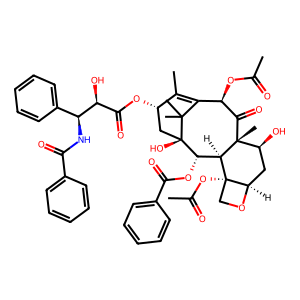

66.33747863769531


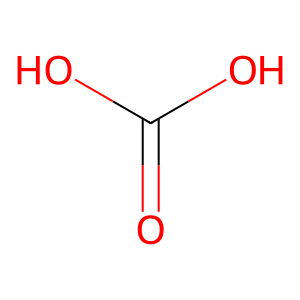

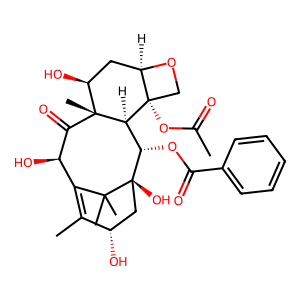

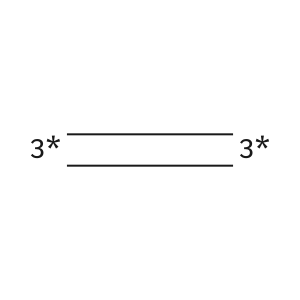

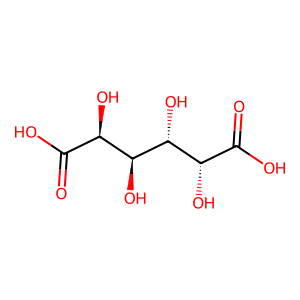

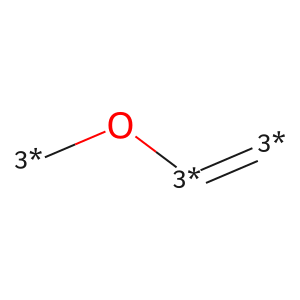

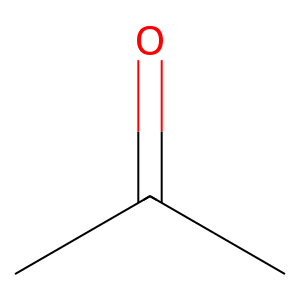

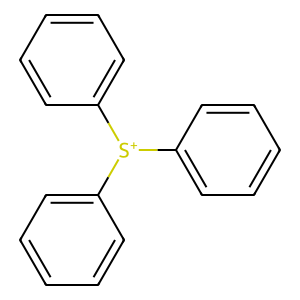

61.05744171142578


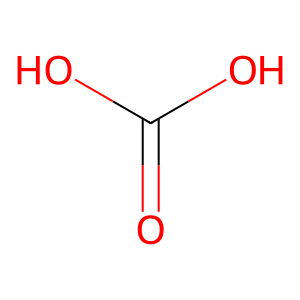

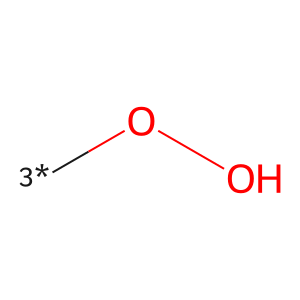

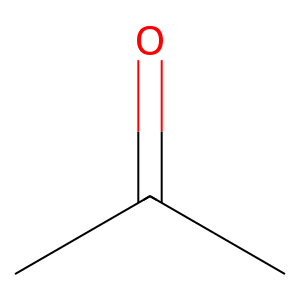

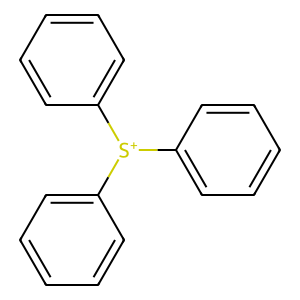

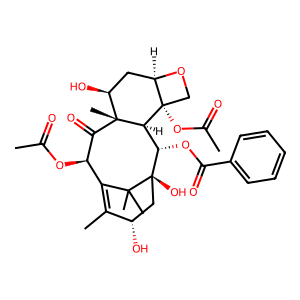

52.119117736816406


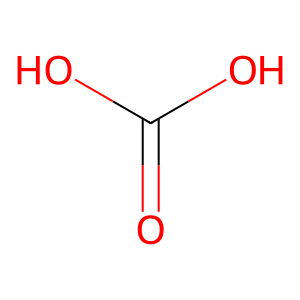

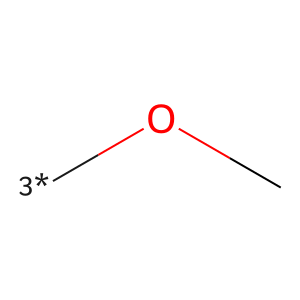

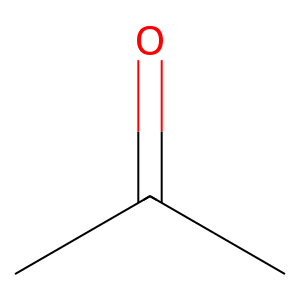

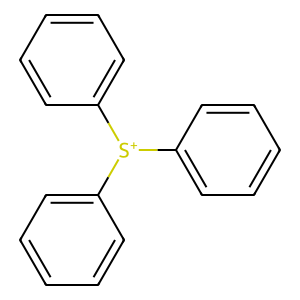

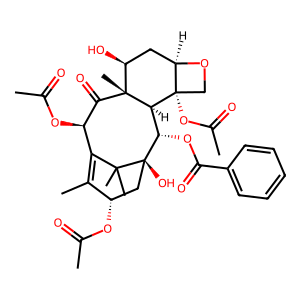

overall yield:  0.2111031043229159


In [15]:
# copy un altered set of molecules
set_mol = set_all.copy()

# set target
testmol2 = "CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@H]3[C@@H]([C@@](C2(C)C)(C[C@@H]1OC(=O)[C@@H]([C@H](C5=CC=CC=C5)NC(=O)C6=CC=CC=C6)O)O)OC(=O)C7=CC=CC=C7)(CO4)OC(=O)C)O)C)OC(=O)C"

# vizualize target
display(Draw.MolToImage(Chem.MolFromSmiles(testmol2), size=(300, 300)))

# run process on target
test2 = process(target = testmol2,
                num_pathways = 1,
                num_steps = 3,
                set_all_molecules = set_mol)

# vizualize pathway
path_viz(test2[0])

>>

>>

# Thank you!